In [ ]:
from PIL import Image
import pandas as pd
import glob
import numpy as np
from PIL import Image
import os
import matplotlib
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.datasets as dsets
from transformers import DefaultDataCollator
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Resize, Compose, Normalize, ToTensor, ToPILImage
from transformers import AutoImageProcessor
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer
from tqdm.auto import tqdm
from sklearn.metrics import classification_report, confusion_matrix, precision_score,recall_score,f1_score, roc_curve, roc_auc_score, matthews_corrcoef
import seaborn as sns
import matplotlib.pyplot as plt
import shutil

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dml = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
%%capture
!cp /content/drive/MyDrive/Upload/* ./
!unzip -o /content/test.zip -d /content/test
!unzip -o /content/swin_transformer.zip -d ./

In [ ]:
class MyDataset(Dataset):

    def __init__(self, ds, processor):

        self.ds = ds
        self.processor = processor
        self.normalize = Normalize(mean=self.processor.image_mean, std=self.processor.image_std)
        self.size = (self.processor.size["shortest_edge"]
                if "shortest_edge" in self.processor.size
                else (self.processor.size["height"], self.processor.size["width"]))

        self.transform = Compose([Resize(self.size), ToTensor(), self.normalize, ToPILImage()])


    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        image_path = self.ds[idx][0]
        label = self.ds[idx][1]
        image = self.transform(Image.open(image_path).convert("RGB"))
        pixel_values = self.processor(image, return_tensors="pt").pixel_values

        return {"pixel_values": pixel_values.squeeze(),
                "label": label,
                "path": image_path}

In [ ]:
checkpoint = "swin_transformer"
image_processor = AutoImageProcessor.from_pretrained(checkpoint)
model = AutoModelForImageClassification.from_pretrained(checkpoint, num_labels=2, ignore_mismatched_sizes=True)
model = model.to(dml)

In [ ]:
test_dataset = dsets.ImageFolder(root='test')
test_ds = MyDataset(ds=test_dataset.imgs, processor=image_processor)
test_loader = DataLoader(test_ds, batch_size=20, drop_last=True, shuffle=False)

In [ ]:
def get_predictions():
    softmax = nn.Softmax(dim=1)
    model.eval()
    predictions = []
    real_values = []
    pred_probas = []
    misclassified = []

    with torch.no_grad():
        for batch in tqdm(test_loader):
            inputs = batch['pixel_values'].to(dml)
            labels = batch['label']
            path = batch['path']

            outputs = softmax(model(inputs).logits)

            _, preds = torch.max(outputs, dim = 1)
            for probs in outputs.cpu():
                pred_probas.append(list(probs.numpy()))

            preds = preds.cpu().numpy()
            labels = labels

            predictions.extend(preds)
            real_values.extend(labels)

            for ind, (actual, pred) in enumerate(zip(labels, preds)):
                if actual != pred:
                    misclassified.append((path[ind], actual, pred))

    return predictions, real_values, pred_probas, misclassified

In [ ]:
pred, real, probas, misclassified = get_predictions()
print(classification_report(real, pred, digits=6))

  0%|          | 0/943 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0   0.965490  0.982941  0.974137      4924
           1   0.993934  0.987586  0.990750     13936

    accuracy                       0.986373     18860
   macro avg   0.979712  0.985263  0.982443     18860
weighted avg   0.986508  0.986373  0.986412     18860



Accuracy: 98.6373276776246%
Precision: 0.9865075033925417
Recall: 0.986373276776246
F1-score: 0.9864124742344608
MCC-score: 0.9649591485539514
ROC AUC score: 0.903907476303417




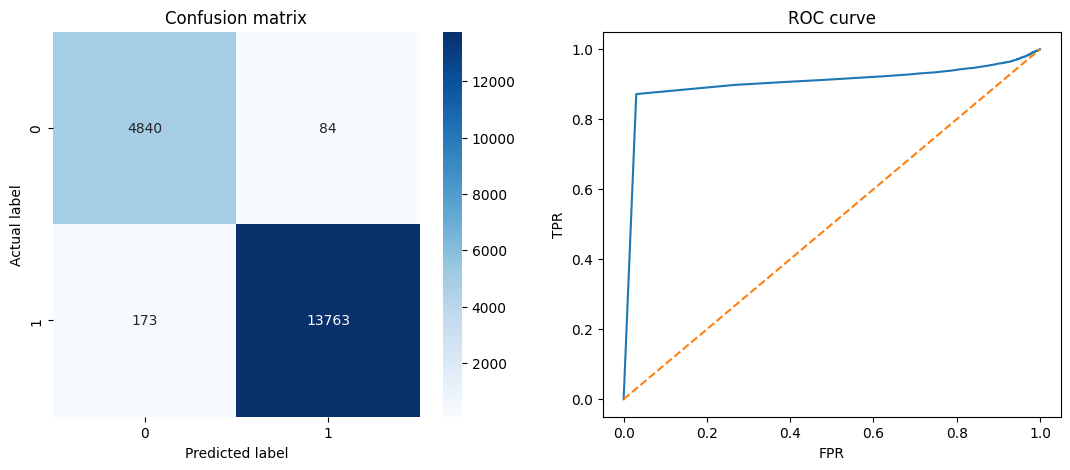

In [ ]:
def score_in_details():
  class_name = [0, 1]
  y_real = real
  y_pred = pred
  pred_score = [max(x) for x in probas]
  accuracy = recall_score(y_real, y_pred, average='weighted')
  precision = precision_score(y_real, y_pred, average='weighted')
  recall = recall_score(y_real, y_pred, average='weighted')
  f1 = f1_score(y_real, y_pred, average='weighted')
  roc_auc = roc_auc_score(y_real, pred_score, average='weighted')
  mcc_score = matthews_corrcoef(y_real, y_pred)
  fpr, tpr, thresholds = roc_curve(y_real, pred_score)

  print(f"Accuracy: {accuracy * 100}%")
  print(f"Precision: {precision}")
  print(f"Recall: {recall}")
  print(f"F1-score: {f1}")
  print(f"MCC-score: {mcc_score}")
  print(f"ROC AUC score: {roc_auc}")

  print()
  print()


  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))
  conf_matrix = confusion_matrix(y_real, y_pred)
  sns.heatmap(pd.DataFrame(conf_matrix), annot=True, cmap ='Blues', fmt='g', xticklabels=class_name, yticklabels=class_name, ax=ax1)
  ax1.set_title('Confusion matrix')
  ax1.set_ylabel('Actual label')
  ax1.set_xlabel('Predicted label')

  ax2.plot(fpr, tpr)
  ax2.plot([0,1], [0,1], linestyle='--')
  ax2.set_ylabel('TPR')
  ax2.set_xlabel('FPR')
  ax2.set_title('ROC curve')

  plt.show()

score_in_details()

In [ ]:
dest = "misclassified"

if not os.path.exists(dest):
  os.mkdir(dest)

for path, actual, predictd in tqdm(misclassified):
  img_name = path.split("/")[-1].split(".")[0]
  ext = path.split(".")[-1]
  shutil.copy(path, os.path.join(dest, f"{img_name}_{actual}_{predictd}.{ext}"))

  0%|          | 0/257 [00:00<?, ?it/s]

In [ ]:
%%capture
!zip -r /content/drive/MyDrive/Upload/misclassified.zip misclassified/*